In [ ]:
# Install required libs
#!pip install -U segmentation-models-pytorch albumentations --user 

In [ ]:
#!pip uninstall -y segmentation-models-pytorch

## Loading data

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = './CamVid/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')

In [3]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [34]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        print(image.shape)
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [250]:
with gzip.open("task3data/test.pkl", 'rb') as f:
    testX = pickle.load(f)

In [268]:
with gzip.open("my_predictions2.pkl", 'rb') as f:
    mpreds = pickle.load(f)

In [194]:
testX[19]["video"][0].shape

(777, 69)

In [203]:
trainX[0]["video"][:,:,0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 0, ..., 1, 0, 0],
       [0, 3, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

In [173]:
mpreds[1]["prediction"][0].shape

(737, 78)

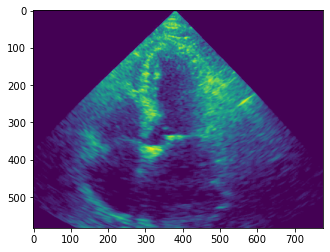

In [281]:
x=50
vid = 19
plt.imshow(testX[vid]["video"][:,:,x])

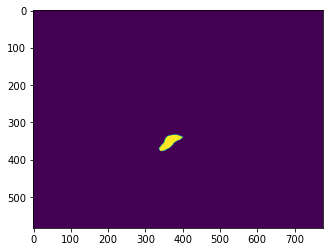

In [282]:
plt.imshow(mpreds[vid]["prediction"][:,:,x])

(112, 112, 1)
(112, 112)
(320, 320, 1)
(320, 320, 1)
(3, 320, 320)
(1, 320, 320)


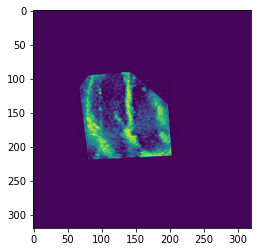

In [226]:
plt.imshow(train_dataset[0][0][0,:,:])

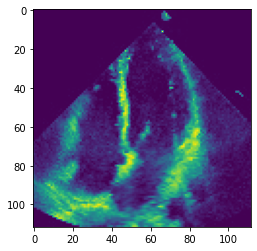

In [229]:
plt.imshow(trainX_extr[0][0])

In [230]:
trainX_extr[0][0].shape

(112, 112)

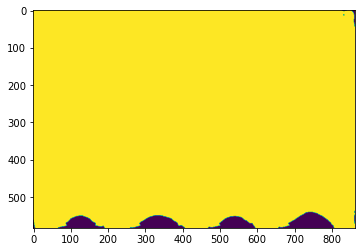

In [231]:
 plt.imshow(mpreds[0]["prediction"][:,:,0])

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [21]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [236]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        print(np.array(image).shape)
        print(np.array(mask).shape)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        print(type(mask))
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        print(np.array(image).shape)
        print(np.array(mask).shape)
        # apply preprocessing
        if self.preprocessing:
            print("in preproc")
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        print(f"ending image {np.array(image).shape}")
        print(f"ending mask {np.array(mask).shape}")
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [23]:
import gzip
import pickle
with gzip.open("task3data/train.pkl", 'rb') as f:
    trainX = pickle.load(f)

In [ ]:
with gzip.open("task3data/sample.pkl", 'rb') as f:
    sample = pickle.load(f)

In [24]:
np.array([1,23,4,5])[[3,1,2]]

array([ 5, 23,  4])

In [ ]:
test

In [25]:
trainX_extr = []
for i in range(len(trainX)):
    video = trainX[i]["video"]
    frames = trainX[i]["frames"]
    frame1 = trainX[i]["video"][:,:,frames[0]]
    frame2 = trainX[i]["video"][:,:,frames[1]]
    frame3 = trainX[i]["video"][:,:,frames[2]]
    label1 = trainX[i]["label"][:,:,frames[0]]
    label2 = trainX[i]["label"][:,:,frames[1]]
    label3 = trainX[i]["label"][:,:,frames[2]]
    trainX_extr.append((frame1,label1))
    trainX_extr.append((frame2,label2))
    trainX_extr.append((frame3,label3))

#trainX_extr = [(trainX[i]["video"][:,:,trainX[i]["frames"]],trainX[i]["label"][:,:,trainX[i]["frames"]]) for i in range(65)]

In [126]:
test_data = []
for i in range(len(testX)):
    video = testX[i]["video"]
    for j in range(video.shape[2]):
        test_data.append(video[:,:,j])

In [154]:
class Dataset2(BaseDataset):
    """mitral valve Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['valve']
    
    def __init__(
            self, 
            data,
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.data = data
        self.images_fps = [pair[0] for pair in self.data]
        self.masks_fps = [pair[1] for pair in self.data]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
#        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#        mask = cv2.imread(self.masks_fps[i], 0)
        
        image = self.images_fps[i][:,:,np.newaxis]
        mask = self.masks_fps[i]
        print(np.array(image).shape)
        print(np.array(mask).shape)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        print(f"image has shape {np.array(image).shape}")
        print(f"mask has shape{np.array(mask).shape}")
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        print(np.array(image).shape)
        print(np.array(mask).shape)  
        return image, mask
        
    def __len__(self):
        return len(self.data)

(360, 480, 3)
(360, 480)
<class 'numpy.ndarray'>
(360, 480, 3)
(360, 480, 1)
ending image (360, 480, 3)
ending mask (360, 480, 1)
(360, 480, 3)
(360, 480)


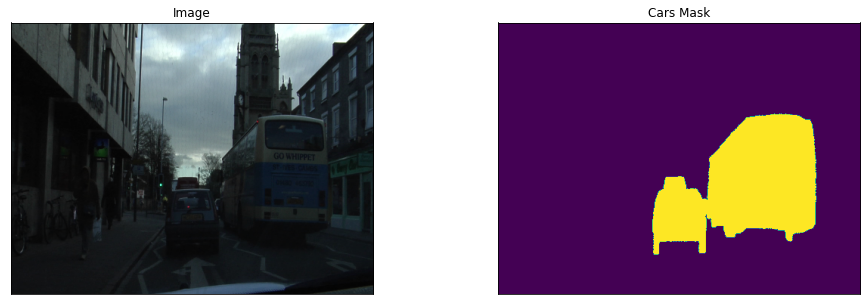

In [237]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, classes=['car'])

image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

In [63]:
dataset2[0]

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 3, ..., 1, 0, 0],
        [3, 2, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],
 
        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],
 
        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],
 
        ...,
 
        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],
 
        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],
 
        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]]]))

(112, 112, 1)
(112, 112)
image has shape (112, 112, 1)
mask has shape(112, 112, 1)
(112, 112, 1)
(112, 112, 1)
(112, 112, 1)
(112, 112)


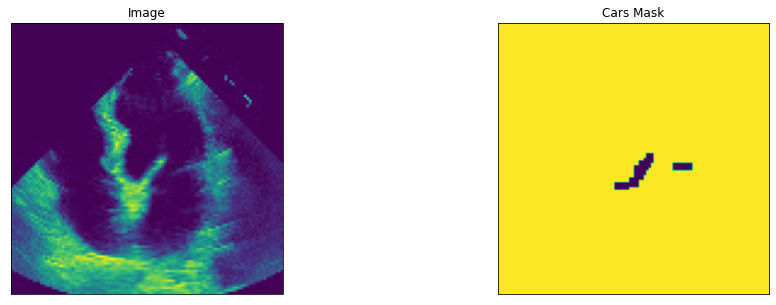

In [155]:
# Lets look at data we have

dataset2 = Dataset2(trainX_extr, classes=['valve'])

image, mask = dataset2[56] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

In [101]:
testX[1]

{'name': '401JD35E1A',
 'video': array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        ...,
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
 

In [ ]:
dataset3 = Dataset2(trainX_extr, classes=['valve'])


### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [46]:
import albumentations as albu

In [47]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

<class 'numpy.ndarray'>

(320, 320, 3)
(320, 320)


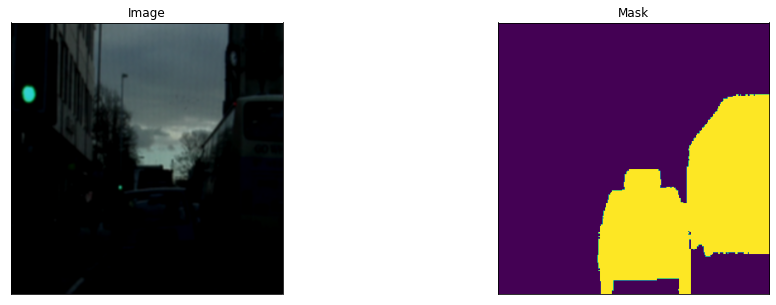

<class 'numpy.ndarray'>

(320, 320, 3)
(320, 320)


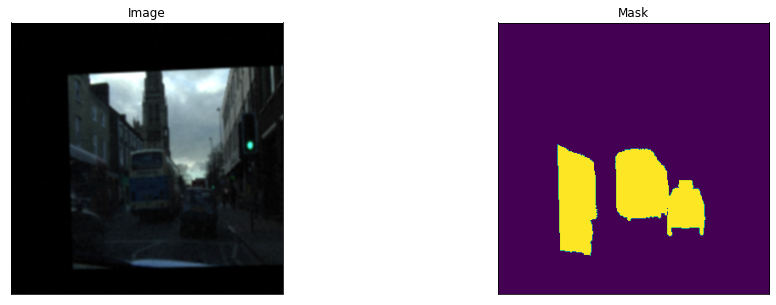

<class 'numpy.ndarray'>

(320, 320, 3)
(320, 320)


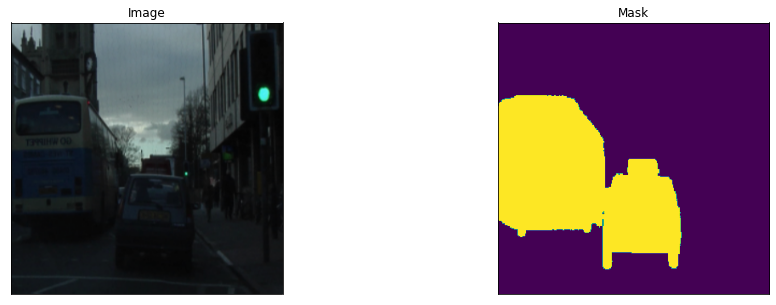

In [64]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['car'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))

(586, 821, 1)
(586, 821)
(320, 320, 1)
(320, 320, 1)
(320, 320, 1)
(320, 320, 1)
(320, 320, 1)
(320, 320)


C:\Users\Marios\.conda\envs\aml_task_3\lib\site-packages\albumentations\imgaug\transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
C:\Users\Marios\.conda\envs\aml_task_3\lib\site-packages\albumentations\imgaug\transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
C:\Users\Marios\.conda\envs\aml_task_3\lib\site-packages\albumentations\augmentations\transforms.py:1744: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
C:\Users\Marios\.conda\envs\aml_task_3\lib\site-packages\albumentations\imgaug\transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen 

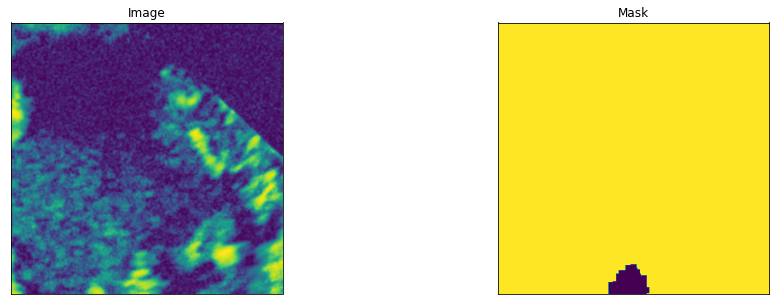

(586, 821, 1)
(586, 821)
(320, 320, 1)
(320, 320, 1)
(320, 320, 1)
(320, 320, 1)
(320, 320, 1)
(320, 320)


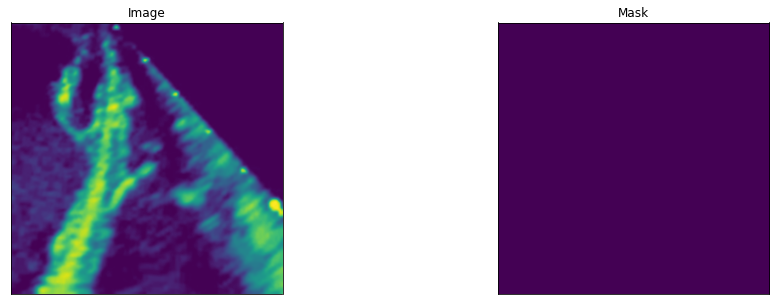

(586, 821, 1)
(586, 821)
(320, 320, 1)
(320, 320, 1)
(320, 320, 1)
(320, 320, 1)
(320, 320, 1)
(320, 320)


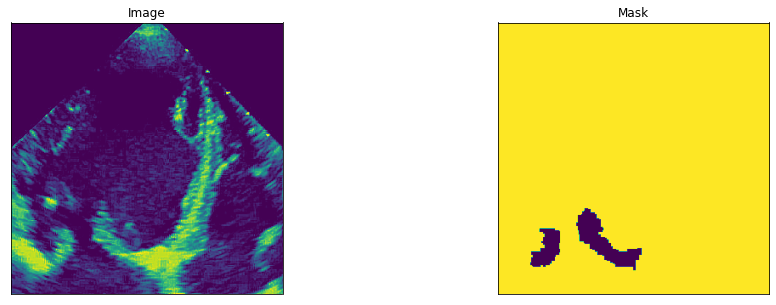

In [147]:
#### Visualize resulted augmented images and masks

augmented_dataset2 = Dataset2(
     trainX_extr, 
    classes=['valve'],
    augmentation=get_training_augmentation(), 
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset2[150]
    visualize(image=image, mask=mask.squeeze(-1))

In [140]:
trainX[50]["video"].shape

(586, 821, 103)

In [145]:
augmented_dataset[2][0].dtype

<class 'numpy.ndarray'>



dtype('uint8')

## Create model and train

In [50]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [51]:
torch.cuda.is_available = lambda : False
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [75]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['car']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [242]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)#12
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)#4

(360, 480, 3)
(360, 480)
<class 'numpy.ndarray'>
(320, 320, 3)
(320, 320, 1)
in preproc
ending image (3, 320, 320)
ending mask (1, 320, 320)


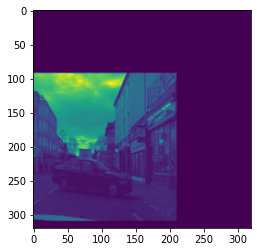

In [249]:
plt.imshow(train_dataset[50][0][0,:,:])

In [93]:
train_dataset[0]
# (360, 480, 3)
# (360, 480)
# <class 'numpy.ndarray'>
# (320, 320, 3)
# (320, 320, 1)
# (3, 320, 320)
# (1, 320, 320)

(112, 112, 1)
(112, 112)
(320, 320, 1)
(320, 320, 1)
(3, 320, 320)
(1, 320, 320)


(array([[[-2.117904 , -2.117904 , -2.117904 , ..., -2.117904 ,
          -2.117904 , -2.117904 ],
         [-2.117904 , -2.117904 , -2.117904 , ..., -2.117904 ,
          -2.117904 , -2.117904 ],
         [-2.117904 , -2.117904 , -2.117904 , ..., -2.117904 ,
          -2.117904 , -2.117904 ],
         ...,
         [-2.117904 , -2.117904 , -2.117904 , ..., -2.117904 ,
          -2.117904 , -2.117904 ],
         [-2.117904 , -2.117904 , -2.117904 , ..., -2.117904 ,
          -2.117904 , -2.117904 ],
         [-2.117904 , -2.117904 , -2.117904 , ..., -2.117904 ,
          -2.117904 , -2.117904 ]],
 
        [[-2.0357144, -2.0357144, -2.0357144, ..., -2.0357144,
          -2.0357144, -2.0357144],
         [-2.0357144, -2.0357144, -2.0357144, ..., -2.0357144,
          -2.0357144, -2.0357144],
         [-2.0357144, -2.0357144, -2.0357144, ..., -2.0357144,
          -2.0357144, -2.0357144],
         ...,
         [-2.0357144, -2.0357144, -2.0357144, ..., -2.0357144,
          -2.0357144, -2

In [92]:
train_dataset = Dataset2(
     trainX_extr[:170], 
    classes=['valve'],
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)


valid_dataset = Dataset2(
     trainX_extr[170:], 
    classes=['valve'],
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)


train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)#12
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)#4

In [56]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [57]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [25]:
# train model for 40 epochs

max_score = 0
for i in range(0, 40):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|                                                                                   | 0/367 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 1.99 GiB already allocated; 17.05 MiB free; 2.05 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [20]:
torch.cuda.empty_cache()

In [40]:
torch.cuda.is_available()

False

In [41]:
torch.cuda.current_device()

0

In [42]:
torch.cuda.device(0)

In [43]:
torch.cuda.device_count()

0

In [44]:
torch.cuda.get_device_name(0)

AssertionError: Invalid device id

## Test best saved model

In [20]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [21]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [22]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 233/233 [00:08<00:00, 27.19it/s, dice_loss - 0.1979, iou_score - 0.7498]


## Visualize predictions

In [132]:
class Dataset3(BaseDataset):
    """mitral valve Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['valve']
    
    def __init__(
            self, 
            data,
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.data = data
        self.images_fps = [pair for pair in self.data]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        image = self.images_fps[i][:,:,np.newaxis]
        print(np.array(image).shape)
        
        # apply augmentations
        if self.augmentation:
            print(image.shape)
            sample = self.augmentation(image=image, mask=np.ones(image.shape))
            image, mask = sample['image'], sample['mask']
            print(image.shape)
        print(np.array(image).shape)
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=np.ones(image.shape))
            image, mask = sample['image'], sample['mask']
        print(np.array(image).shape)

        return image
        
    def __len__(self):
        return len(self.data)

In [133]:
test_dataset = Dataset3(
    test_data,
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=["valve"]
)

In [136]:
train_dataset[0]

(112, 112, 1)
(112, 112)
(320, 320, 1)
(320, 320, 1)
(3, 320, 320)
(1, 320, 320)


(array([[[-2.117904 , -2.117904 , -2.117904 , ..., -2.117904 ,
          -2.117904 , -2.117904 ],
         [-2.117904 , -2.117904 , -2.117904 , ..., -2.117904 ,
          -2.117904 , -2.117904 ],
         [-2.117904 , -2.117904 , -2.117904 , ..., -2.117904 ,
          -2.117904 , -2.117904 ],
         ...,
         [-2.117904 , -2.117904 , -2.117904 , ..., -2.117904 ,
          -2.117904 , -2.117904 ],
         [-2.117904 , -2.117904 , -2.117904 , ..., -2.117904 ,
          -2.117904 , -2.117904 ],
         [-2.117904 , -2.117904 , -2.117904 , ..., -2.117904 ,
          -2.117904 , -2.117904 ]],
 
        [[-2.0357144, -2.0357144, -2.0357144, ..., -2.0357144,
          -2.0357144, -2.0357144],
         [-2.0357144, -2.0357144, -2.0357144, ..., -2.0357144,
          -2.0357144, -2.0357144],
         [-2.0357144, -2.0357144, -2.0357144, ..., -2.0357144,
          -2.0357144, -2.0357144],
         ...,
         [-2.0357144, -2.0357144, -2.0357144, ..., -2.0357144,
          -2.0357144, -2

In [135]:
test_dataset[0]

(583, 863, 1)
(583, 863, 1)
(583, 863, 1)
(583, 863, 1)
(3, 583, 863)


array([[[-2.117904 , -2.117904 , -2.117904 , ..., -2.117904 ,
         -2.117904 , -2.117904 ],
        [-2.117904 , -2.117904 , -2.117904 , ..., -2.117904 ,
         -2.117904 , -2.117904 ],
        [-2.117904 , -2.117904 , -2.117904 , ..., -2.117904 ,
         -2.117904 , -2.117904 ],
        ...,
        [-2.117904 , -2.117904 , -2.117904 , ..., -2.117904 ,
         -2.117904 , -2.117904 ],
        [-2.117904 , -2.117904 , -2.117904 , ..., -2.117904 ,
         -2.117904 , -2.117904 ],
        [-2.117904 , -2.117904 , -2.117904 , ..., -2.117904 ,
         -2.117904 , -2.117904 ]],

       [[-2.0357144, -2.0357144, -2.0357144, ..., -2.0357144,
         -2.0357144, -2.0357144],
        [-2.0357144, -2.0357144, -2.0357144, ..., -2.0357144,
         -2.0357144, -2.0357144],
        [-2.0357144, -2.0357144, -2.0357144, ..., -2.0357144,
         -2.0357144, -2.0357144],
        ...,
        [-2.0357144, -2.0357144, -2.0357144, ..., -2.0357144,
         -2.0357144, -2.0357144],
        [-2.

In [23]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

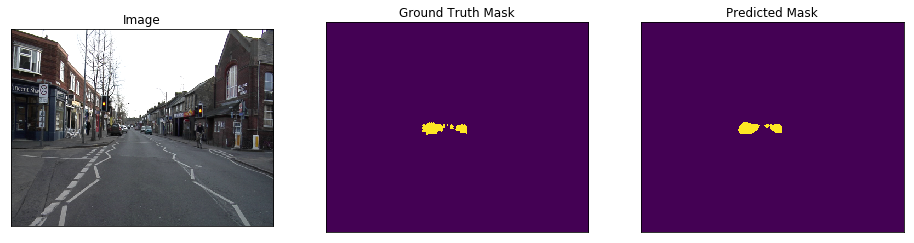

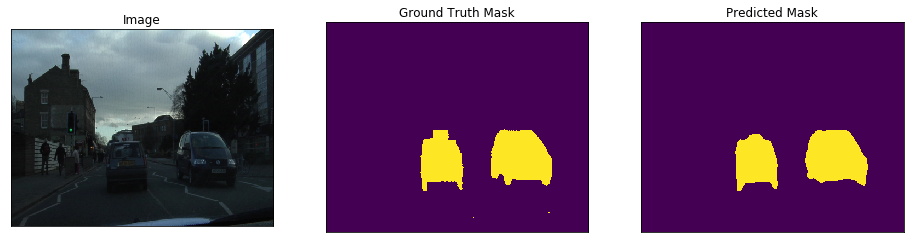

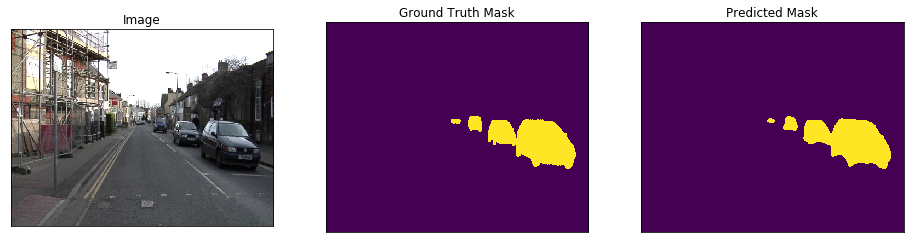

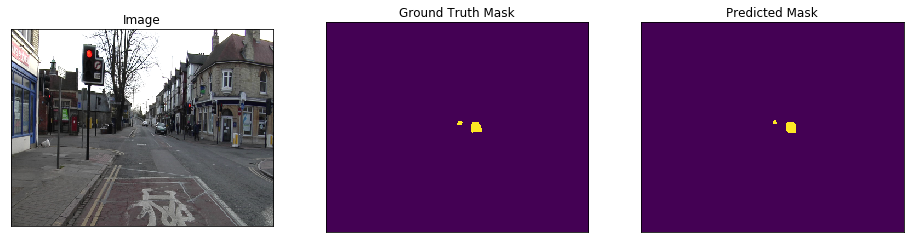

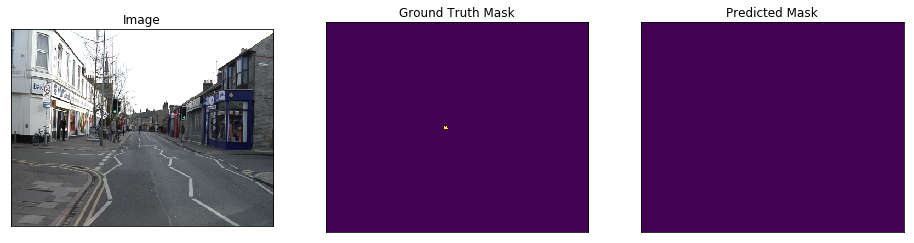

In [24]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )